In [1]:
import torch
import numpy as np
import time

from collections import defaultdict
from typing import List
from conllu import parse_incr, TokenList
from torch import Tensor
from transformers import GPT2Model, GPT2Tokenizer
CUTOFF = None
from lstm.model import RNNModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transformer = GPT2Model.from_pretrained('distilgpt2', output_hidden_states=True)
print("Model ready")
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
print("Tokenizer ready")
# Note that some models don't return the hidden states by default.
# This can be configured by passing `output_hidden_states=True` to the `from_pretrained` method.

Model ready
Tokenizer ready


In [3]:
# The Gulordava LSTM model can be found here: 
# https://drive.google.com/open?id=1w47WsZcZzPyBKDn83cMNd0Hb336e-_Sy
#
# N.B: I have altered the RNNModel code to only output the hidden states that you are interested in.
# If you want to do more experiments with this model you could have a look at the original code here:
# https://github.com/facebookresearch/colorlessgreenRNNs/blob/master/src/language_models/model.py
#
model_location = 'lstm/gulordava.pt'
lstm = RNNModel('LSTM', 50001, 650, 650, 2)
lstm.load_state_dict(torch.load(model_location))


# This LSTM does not use a Tokenizer like the Transformers, but a Vocab dictionary that maps a token to an id.
with open('lstm/vocab.txt') as f:
    w2i = {w.strip(): i for i, w in enumerate(f)}

vocabLSTM = defaultdict(lambda: w2i["<unk>"])
vocabLSTM.update(w2i)
i2w = { w2i[k]:k for k in w2i}

## Load All Data

In [4]:
from utils import create_or_load_pos_data
from controltasks import save_or_load_pos_controls 
from datasets import find_distribution, POSDataset
import torch.utils.data as data 
import time

train_x, train_y, vocab, words_train = create_or_load_pos_data("train", transformer, tokenizer, cutoff=CUTOFF)
dev_x, dev_y, vocab, words_dev = create_or_load_pos_data("dev", transformer, tokenizer, vocab, cutoff=CUTOFF)
test_x, test_y, vocab, words_test = create_or_load_pos_data("test", transformer, tokenizer, vocab, cutoff=CUTOFF)

flatten_train = [word for sublist in words_train for word in sublist]
flatten_dev   = [word for sublist in words_dev for word in sublist]
flatten_test  = [word for sublist in words_test for word in sublist]
dist = find_distribution(data.DataLoader(POSDataset(train_x, train_y), batch_size=1))
ypos_train_control, ypos_dev_control, ypos_test_control = save_or_load_pos_controls(
    train_x, train_y, [flatten_train, flatten_dev, flatten_test], dist)

In [5]:
train_xL, train_yL, vocab, _ = create_or_load_pos_data("train", lstm, vocabLSTM, cutoff=CUTOFF)
dev_xL, dev_yL, vocab, _ = create_or_load_pos_data("dev", lstm, vocabLSTM, vocab, cutoff=CUTOFF)
test_xL, test_yL, vocab, _ = create_or_load_pos_data("test", lstm, vocabLSTM, vocab, cutoff=CUTOFF)


In [ ]:
from tree_utils import create_or_load_structural_data
from controltasks import save_or_load_struct_controls

train_xy = create_or_load_structural_data("train", transformer, tokenizer, cutoff=CUTOFF)
dev_xy = create_or_load_structural_data("dev", transformer, tokenizer, cutoff=CUTOFF)
test_xy = create_or_load_structural_data("test", transformer, tokenizer, cutoff=CUTOFF)
print(len(train_xy))
struct_train_control, struct_dev_control, struct_test_control = save_or_load_struct_controls(cutoff=CUTOFF)

## PoS Models

In [6]:
# DIAGNOSTIC CLASSIFIER
import torch.nn as nn
import copy
class POSProbe(nn.Module):
    def __init__(self, repr_size, pos_size, hidden_size = 0, dropout=0):
        super().__init__()
        if hidden_size == 0:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, pos_size))
        else:
            self.linear = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(repr_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(hidden_size, pos_size)
            )
        
    def forward(self, x):
        return self.linear(x)
    
def eval_given_dataloader(loader, model):
    model.eval()
    correct = 0.0
    total = 0.0
    for x,y in loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        preds = torch.argmax(outputs,dim=1)
        c = torch.sum(torch.eq(preds, y))
        correct += c.item()
        total += y.shape[0]
    return correct/total
    
def train(my_model, train_loader, dev_loader, epoch_amount = 10, warmup_steps = 5, p=False):
    """
    Given a model, train_loader and dev_loader
    
    Returns state_dict for the best epoch
    """
    ce = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(my_model.parameters())
    patience = 3
    best_model = None
    prev_dev_acc = 0.0
    best_dev_acc = 0.0
    best_epoch = 0
    for i in range(epoch_amount):
        my_model.train()
        epoch_correct = 0.0
        epoch_total = 0.0
        for x,y in train_loader:
            
            x = x.to(device)
            y = y.to(device)
            outputs = my_model(x)
            preds = torch.argmax(outputs,dim=1)
            correct = torch.sum(torch.eq(preds, y))
            accuracy = correct.item()/y.shape[0]
            loss = ce(outputs, y)

            optim.zero_grad()
            loss.backward()
            optim.step()
            
            epoch_correct += correct.item()
            epoch_total += y.shape[0]
            
        dev_acc = eval_given_dataloader(dev_loader, my_model)
        
        if p:
            print("Epoch",i,"accuracy", epoch_correct/epoch_total, dev_acc)        
        if dev_acc < prev_dev_acc and i > warmup_steps:
            patience -= 1
        else:
            patience = 2
        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            best_model = copy.deepcopy(my_model.state_dict())
            best_epoch = i
        prev_dev_acc = dev_acc
        if patience == 0:
            #print("Early stopping")
            break
    return best_model, best_epoch

In [7]:
# MLP vs LINEAR
# Dropout 0.0 0.2 0.4 0.6 0.8 
# POS CONTROLPOS
# RNN vs Transformer
# result_dict[task][model][mlp][dropout][seed] -> bestmodel: statedict, val_acc: float, test_acc:float
import pickle
import os 

if os.path.exists('results_mlp.pickle'):
    raise ValueError("Do not run this ... ")

def eval_model(task, model_type, hidden_size, dropout, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if model_type == 'lstm':
        x_train = train_xL
        x_dev = dev_xL 
        x_test = test_xL
    else:
        x_train = train_x
        x_dev = dev_x
        x_test = test_x
    
    if task == 'pos':
        y_train = train_y
        y_dev = dev_y
        y_test = test_y
    else:
        y_train = ypos_train_control
        y_dev = ypos_dev_control
        y_test = ypos_test_control
        
    train_loader = data.DataLoader(POSDataset(x_train, y_train), batch_size=16, shuffle=True)
    dev_loader = data.DataLoader(POSDataset(x_dev, y_dev), batch_size=16)
    test_loader = data.DataLoader(POSDataset(x_test, y_test), batch_size=16)

    model = POSProbe(768 if model_type == 'transformer' else 650, len(dist), hidden_size, dropout).to(device)
    best_state_dict, epochs = train(model, train_loader, dev_loader, 20, 4)
    model.load_state_dict(best_state_dict)
    dev_acc =  eval_given_dataloader(dev_loader, model)
    test_acc = eval_given_dataloader(test_loader, model)
    return model, dev_acc, test_acc, epochs
print(device)
result_dict_mlp = {}   
for task in [ 'controlpos']:
    result_dict_mlp[task] = {}
    for model_type in ['lstm', 'transformer']:
        print("Starting", model_type)
        result_dict_mlp[task][model_type]= {}
        for hidden_size in [256]:
            result_dict_mlp[task][model_type][hidden_size] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict_mlp[task][model_type][hidden_size][dropout] = {}
                for seed in [10,20,30]:
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed] = {}
                    state_dict, dev_acc, test_acc, epochs = eval_model(task, model_type, hidden_size, dropout, seed)
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['state_dict'] = state_dict
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['dev_acc'] = dev_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['test_acc'] = test_acc
                    result_dict_mlp[task][model_type][hidden_size][dropout][seed]['epochs'] = epochs
                    print(task,model_type,hidden_size,dropout,seed, epochs, test_acc)
                #print(result_dict)       
with open("results_mlpcontrolpos.pickle", "wb") as f:
    pickle.dump(result_dict_mlp, f)
print("All results are safe. You can sleep peacefully. ")

cuda:0
Starting lstm
controlpos lstm 256 0 10 4 0.6767213898629264
controlpos lstm 256 0 20 5 0.6752868983104877
controlpos lstm 256 0 30 4 0.6733742429072362
controlpos lstm 256 0.2 10 16 0.687041759642971
controlpos lstm 256 0.2 20 19 0.6845712464137711
controlpos lstm 256 0.2 30 6 0.6713021995537137
controlpos lstm 256 0.4 10 19 0.6465572202741473
controlpos lstm 256 0.4 20 19 0.645680586547657
controlpos lstm 256 0.4 30 18 0.6455610455849538
controlpos lstm 256 0.6 10 13 0.5783391775581767
controlpos lstm 256 0.6 20 14 0.58057060886197
controlpos lstm 256 0.6 30 18 0.582403570290086
controlpos lstm 256 0.8 10 18 0.46545266177876954
controlpos lstm 256 0.8 20 9 0.46449633407714375
controlpos lstm 256 0.8 30 19 0.4686404207841887
Starting transformer
controlpos transformer 256 0 10 14 0.6807857825948358
controlpos transformer 256 0 20 8 0.674489958559133
controlpos transformer 256 0 30 14 0.6805467006694293
controlpos transformer 256 0.2 10 19 0.6605036659228563
controlpos transforme

/home/anna/.local/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [9]:
with open("results_pos.pickle", "rb") as f:
    mlp_results = pickle.load(f)
    
with open("results_mlpcontrolpos.pickle", "rb") as f:
    mlp_results2 = pickle.load(f)

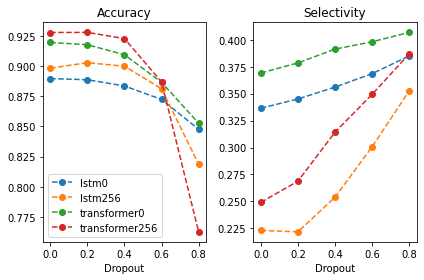

In [15]:
import matplotlib.pyplot as plt
import pickle
with open('Justnumbers.txt', 'rb') as f:
    result_dict = pickle.load(f)
    
def mean_test_acc(the_dict):
    three_accs = [the_dict[z]['test_acc'] for z in the_dict]
    return np.mean(three_accs), np.std(three_accs)

fig, (ax1,ax2) = plt.subplots(1,2)

for model in ['lstm', 'transformer']:
    for hidden_size in [0, 256]:
        x_axis = [0,0.2,0.4,0.6,0.8]
        y_axis = []
        y_axis_control = []
        y_axis_select = []
        for d in x_axis :
            # Mean for POS task
            mean = mean_test_acc(result_dict['pos'][model][hidden_size][d])
            if hidden_size > 0: mean = mean_test_acc(mlp_results['pos'][model][hidden_size][d])
            
            # Mean for Control task
            mean_control = mean_test_acc(result_dict['controlpos'][model][hidden_size][d])
            if hidden_size > 0: mean_control = mean_test_acc(mlp_results2['controlpos'][model][hidden_size][d])
            
            # Append
            y_axis.append(mean[0])
            y_axis_select.append(mean[0] - mean_control[0])

        ax1.plot(x_axis, y_axis, '--o', label=model+str(hidden_size), )
        ax2.plot(x_axis, y_axis_select, '--o')
        ax1.legend()
    
ax1.set_title("Accuracy")
ax2.set_title("Selectivity")
ax1.set_xlabel("Dropout")
ax2.set_xlabel("Dropout")

plt.tight_layout()
plt.show()

In [9]:

raise ValueError("This was a temporary fix. ")
result_dict1 = {}
for task in ['pos', 'controlpos']:
    result_dict1[task] = {}
    for model_type in ['lstm', 'transformer']:
        result_dict1[task][model_type]= {}
        for hidden_size in [0, 256]:
            result_dict1[task][model_type][hidden_size] = {}
            for dropout in [0,0.2,0.4,0.6,0.8]:
                result_dict1[task][model_type][hidden_size][dropout] = {}
                for seed in [10,20,30]:
                    result_dict1[task][model_type][hidden_size][dropout][seed] = {}
                    result_dict1[task][model_type][hidden_size][dropout][seed]['dev_acc'] =result_dict[task][model_type][hidden_size][dropout][seed]['dev_acc']
                    result_dict1[task][model_type][hidden_size][dropout][seed]['test_acc'] =result_dict[task][model_type][hidden_size][dropout][seed]['test_acc']                    
                    result_dict1[task][model_type][hidden_size][dropout][seed]['epochs'] =result_dict[task][model_type][hidden_size][dropout][seed]['epochs']                    
 

ValueError: This was a temporary fix. 

In [21]:


# Normal task
ntrain_loader = data.DataLoader(POSDataset(train_x, train_y), batch_size=16, shuffle=True)
ndev_loader = data.DataLoader(POSDataset(dev_x, dev_y), batch_size=16)
ntest_loader = data.DataLoader(POSDataset(test_x, test_y), batch_size=16)

model = POSProbe(768, len(dist), hidden_size=256).to(device)
model.load_state_dict(train(model, ntrain_loader, ndev_loader, 20, 6, p=True))
print("Dev accuracy", eval_given_dataloader(ndev_loader, model))
print("Test accuracy", eval_given_dataloader(ntest_loader, model))

Epoch 0 accuracy 0.9034191167485397 0.9160171783044377
Epoch 1 accuracy 0.9309333528851089 0.9188006998568474
Epoch 2 accuracy 0.9378204658210524 0.9171305869254016
Epoch 3 accuracy 0.9428745997995943 0.9214251630348338
Epoch 4 accuracy 0.9461446342595987 0.9270319707332592
Epoch 5 accuracy 0.9484810714372999 0.9250039764593606


KeyboardInterrupt: 

In [ ]:
lstmtrain_loader = data.DataLoader(POSDataset(train_xL, train_yL), batch_size=16, shuffle=True)
lstmdev_loader = data.DataLoader(POSDataset(dev_xL, dev_yL), batch_size=16)
lstmtest_loader = data.DataLoader(POSDataset(test_xL, test_yL), batch_size=16)
print(train_xL.shape, train_yL.shape)
model = POSProbe(650, len(dist)).to(device)
model.load_state_dict(train(model, lstmtrain_loader, lstmdev_loader, 20,6))
print("Dev accuracy", eval_given_dataloader(lstmdev_loader, model))
print("Test accuracy", eval_given_dataloader(lstmtest_loader, model))

In [22]:
# Normal task
ctrain_loader = data.DataLoader(POSDataset(train_x, ypos_train_control), batch_size=16)
cdev_loader = data.DataLoader(POSDataset(dev_x, ypos_dev_control), batch_size=16)
ctest_loader = data.DataLoader(POSDataset(test_x, ypos_test_control), batch_size=16)
print(train_x.shape, ypos_train_control.shape)
model = POSProbe(768, len(dist), hidden_size=256).to(device)
model.load_state_dict(train(model, ctrain_loader, cdev_loader, 20, p=True))
print("Test accuracy", eval_given_dataloader(ctest_loader, model))

torch.Size([204585, 768]) (204585,)
Epoch 0 accuracy 0.5665322482097905 0.5875218705264832
Epoch 1 accuracy 0.6460297675782682 0.6224351837124225
Epoch 2 accuracy 0.6769215729403426 0.628240814378877
Epoch 3 accuracy 0.6952904660654495 0.6398123111181804
Epoch 4 accuracy 0.7086247769875602 0.6393351359949101
Epoch 5 accuracy 0.7182638023315492 0.6470097025608398
Epoch 6 accuracy 0.7262164870347289 0.6505487513917608
Epoch 7 accuracy 0.7332746780066964 0.6466518212183872
Epoch 8 accuracy 0.7395019185179754 0.6517416891999364
Epoch 9 accuracy 0.7446342595986998 0.6437490058851598
Epoch 10 accuracy 0.7490334090964635 0.6550421504692222
Epoch 11 accuracy 0.7530268592516558 0.6587800222681724
Epoch 12 accuracy 0.7560818241806584 0.6526165102592651
Epoch 13 accuracy 0.7603147835862845 0.6552409734372515


KeyboardInterrupt: 

In [ ]:
# Normal task
ctrain_loader = data.DataLoader(POSDataset(train_xL, ypos_train_control), batch_size=16)
cdev_loader = data.DataLoader(POSDataset(dev_xL, ypos_dev_control), batch_size=16)
ctest_loader = data.DataLoader(POSDataset(test_xL, ypos_test_control), batch_size=16)
print(train_x.shape, ypos_train_control.shape)
model = POSProbe(650, len(dist)).to(device)
model.load_state_dict(train(model, ctrain_loader, cdev_loader, 20))
print("Test accuracy", eval_given_dataloader(ctest_loader, model))

## Structural

In [59]:
# Control task
from tree_utils import * 
from utils import parse_corpus 

def get_behaviour(behave_dict, token):
    if token in behave_dict:
        return behave_dict[token]
    return np.random.choice(["beginning", "ending"],p=[1/2,1/2])

def fake_gold_distances(corpus, behave_dict):
    all_distances = []
    ind = 0
    for item in corpus:
        ind += 1
        n = len(item)
        modified_heads = np.zeros(n)
        words = []
        
        for word in item:
            i = word['id']
            words.append(word['form'])
            print(i, word['form'], word['head'])
            behaviour = get_behaviour(behave_dict, word['form'])
            if behaviour == "beginning":
                modified_heads[i-1] = 1 
            elif behaviour == "ending":
                modified_heads[i-1] = n
        print("===========================TRUE")
        test = tokentree_to_ete(item.to_tree())
        dists = torch.zeros(n,n)
        for node1 in test.traverse():
            for node2 in test.traverse():
                no1 = int(node1.name) - 1
                no2 = int(node2.name) - 1
                dists[no1,no2] = node1.get_distance(node2)
                
        #[node2.get_distance(node1) for node2 in test.traverse() for node1 in test.traverse()]
        print([node.name for node in test.traverse()])
        # Turn it into a tensor, view, append
        dists = torch.tensor(dists)
        dists = dists.view(n,n)
        mst = create_mst(dists)
        print(dists)
        print(mst)
        ed = edges(mst)
        print_tikz([],ed, words, "TRUEnumber" + str(ind))
        print(ed)
        
        for i, z in enumerate(item):
            new_head = int(modified_heads[i])
            print(i+1, item[i]['form'], new_head)
            z['head'] = new_head
            current = z['deps']
            z['deps'] = (current[0], new_head)
            
            if i == 0 :
                z['head'] = 0
                z['deps'] = (current[0],0)
            elif i == (n-1):
                z['head'] = 1
                z['deps'] = (current[0],1)
            
        print("===========================FAKE")
        tokentree = item.to_tree()
        test = tokentree_to_ete(tokentree)
        #print(test)
        #print("Tree",tokentree_to_nltk(tokentree))
        dists = torch.zeros(n,n)
        for node1 in test.traverse():
            for node2 in test.traverse():
                no1 = int(node1.name) - 1
                no2 = int(node2.name) - 1
                dists[no1,no2] = node1.get_distance(node2)
        # Turn it into a tensor, view, append
        dists = torch.tensor(dists)
        dists = dists.view(n,n)
        mst = create_mst(dists)
        print(dists)
        print(mst)
        ed = edges(mst)
        print_tikz([],ed, words, "number" + str(ind))
        print(ed)
        all_distances.append(dists)
    return all_distances, behave_dict

corp = parse_corpus(os.path.join('data', 'en_ewt-ud-'+'train'+'.conllu'))[1:3]
fake_gold_distances(corp, {})

1 [ 10
2 This 3
3 killing 10
4 of 7
5 a 7
6 respected 7
7 cleric 3
8 will 10
9 be 10
10 causing 0
11 us 10
12 trouble 10
13 for 14
14 years 10
15 to 16
16 come 14
17 . 10
18 ] 10
===========================TRUE
['10', '1', '3', '8', '9', '11', '12', '14', '17', '18', '2', '7', '13', '16', '4', '5', '6', '15']
tensor([[0., 3., 2., 4., 4., 4., 3., 2., 2., 1., 2., 2., 3., 2., 4., 3., 2., 2.],
        [3., 0., 1., 3., 3., 3., 2., 3., 3., 2., 3., 3., 4., 3., 5., 4., 3., 3.],
        [2., 1., 0., 2., 2., 2., 1., 2., 2., 1., 2., 2., 3., 2., 4., 3., 2., 2.],
        [4., 3., 2., 0., 2., 2., 1., 4., 4., 3., 4., 4., 5., 4., 6., 5., 4., 4.],
        [4., 3., 2., 2., 0., 2., 1., 4., 4., 3., 4., 4., 5., 4., 6., 5., 4., 4.],
        [4., 3., 2., 2., 2., 0., 1., 4., 4., 3., 4., 4., 5., 4., 6., 5., 4., 4.],
        [3., 2., 1., 1., 1., 1., 0., 3., 3., 2., 3., 3., 4., 3., 5., 4., 3., 3.],
        [2., 3., 2., 4., 4., 4., 3., 0., 2., 1., 2., 2., 3., 2., 4., 3., 2., 2.],
        [2., 3., 2., 4., 4., 4., 

<ipython-input-59-497508b6b83f>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dists = torch.tensor(dists)
<ipython-input-59-497508b6b83f>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dists = torch.tensor(dists)


([tensor([[0., 1., 2., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 2., 2., 1.],
          [1., 0., 3., 2., 3., 3., 3., 2., 2., 3., 2., 3., 3., 3., 3., 3., 3., 2.],
          [2., 3., 0., 3., 2., 2., 2., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 1.],
          [1., 2., 3., 0., 3., 3., 3., 2., 2., 3., 2., 3., 3., 3., 3., 3., 3., 2.],
          [2., 3., 2., 3., 0., 2., 2., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 1.],
          [2., 3., 2., 3., 2., 0., 2., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 1.],
          [2., 3., 2., 3., 2., 2., 0., 3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 1.],
          [1., 2., 3., 2., 3., 3., 3., 0., 2., 3., 2., 3., 3., 3., 3., 3., 3., 2.],
          [1., 2., 3., 2., 3., 3., 3., 2., 0., 3., 2., 3., 3., 3., 3., 3., 3., 2.],
          [2., 3., 2., 3., 2., 2., 2., 3., 3., 0., 3., 2., 2., 2., 2., 2., 2., 1.],
          [1., 2., 3., 2., 3., 3., 3., 2., 2., 3., 0., 3., 3., 3., 3., 3., 3., 2.],
          [2., 3., 2., 3., 2., 2., 2., 3., 3., 2., 3., 0., 2., 2., 2., 2., 2

In [ ]:
import torch.nn as nn
import torch


class StructuralProbe(nn.Module):
    """ Computes squared L2 distance after projection by a matrix.
    For a batch of sentences, computes all n^2 pairs of distances
    for each sentence in the batch.
    """
    def __init__(self, model_dim, rank, device="cpu"):
        super().__init__()
        self.probe_rank = rank
        self.model_dim = model_dim
        
        self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
        
        nn.init.uniform_(self.proj, -0.05, 0.05)
        self.to(device)

    def forward(self, batch):
        """ Computes all n^2 pairs of distances after projection
        for each sentence in a batch.
        Note that due to padding, some distances will be non-zero for pads.
        Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j
        Args:
          batch: a batch of word representations of the shape
            (batch_size, max_seq_len, representation_dim)
        Returns:
          A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
        """
        transformed = torch.matmul(batch, self.proj)
        
        batchlen, seqlen, rank = transformed.size()
        
        transformed = transformed.unsqueeze(2)
        transformed = transformed.expand(-1, -1, seqlen, -1)
        transposed = transformed.transpose(1,2)
        
        diffs = transformed - transposed
        
        squared_diffs = diffs.pow(2)
        squared_distances = torch.sum(squared_diffs, -1)

        return squared_distances

    
class L1DistanceLoss(nn.Module):
    """Custom L1 loss for distance matrices."""
    def __init__(self):
        super().__init__()

    def forward(self, predictions, label_batch, length_batch):
        """ Computes L1 loss on distance matrices.
        Ignores all entries where label_batch=-1
        Normalizes first within sentences (by dividing by the square of the sentence length)
        and then across the batch.
        Args:
          predictions: A pytorch batch of predicted distances
          label_batch: A pytorch batch of true distances
          length_batch: A pytorch batch of sentence lengths
        Returns:
          A tuple of:
            batch_loss: average loss in the batch
            total_sents: number of sentences in the batch
        """
        labels_1s = (label_batch != -1).float()
        predictions_masked = predictions * labels_1s
        labels_masked = label_batch * labels_1s
        total_sents = torch.sum((length_batch != 0)).float()
        squared_lengths = length_batch.pow(2).float()

        if total_sents > 0:
            loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=(1,2))
            normalized_loss_per_sent = loss_per_sent / squared_lengths
            batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
        
        else:
            batch_loss = torch.tensor(0.0)
        
        return batch_loss, total_sents

In [ ]:
from torch import optim
import math
import tree_utils
import importlib
importlib.reload(tree_utils)

# I recommend you to write a method that can evaluate the UUAS & loss score for the dev (& test) corpus.
# Feel free to alter the signature of this method.
def evaluate_probe(probe, dataloader):
    loss_function =  L1DistanceLoss()
    probe.eval()
    total_loss = 0.0
    total_uuas = 0.0
    amt = 0.0
    for distances, embs, lengths in dataloader:
        embs = embs.to(device)
        distances = distances.to(device)
        lengths = lengths.to(device)
        amt += len(distances)
        outputs = probe(embs)
        loss = loss_function(outputs, distances, lengths)[0]
        total_loss += loss.item()
        for i in range(len(distances)):
            l = lengths[i]
            preds = outputs[i,0:l, 0:l]
            gold = distances[i,0:l, 0:l]
            
            u = tree_utils.calc_uuas(preds, gold)
            if math.isnan(u):
                amt -= 1
            # This if statement is a hack so nans don't get counted
            if u >= 0: total_uuas += u
    
    return total_loss/amt, total_uuas/amt

# Feel free to alter the signature of this method.
def train_structural(probe, dataloader, dev_dataloader,test_loader, epochs=100):
    lr = 1e-5
    batch_size = 128
    
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,patience=1)
    loss_function =  L1DistanceLoss()

    for epoch in range(epochs):
        probe.train()
        for distances, embs, lengths in dataloader:
            embs = embs.to(device)
            distances = distances.to(device)
            lengths = lengths.to(device)
            outputs = probe(embs)
            loss = loss_function(outputs, distances, lengths)[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        dev_loss, dev_uuas = evaluate_probe(probe, dev_dataloader)
        print("Epoch", epoch, "Dev loss and uuas", dev_loss, dev_uuas)
        # Using a scheduler is up to you, and might require some hyper param fine-tuning
        #scheduler.step(dev_loss)

    test_loss, test_uuas = evaluate_probe(probe, test_loader)
    print("Test loss, uuas", test_loss, test_uuas)


In [ ]:

from datasets import StructuralDataset, pad_batch

batch_size = 32
train_loader = data.DataLoader(StructuralDataset(*train_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)
dev_loader = data.DataLoader(StructuralDataset(*dev_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)
test_loader = data.DataLoader(StructuralDataset(*test_xy), batch_size=batch_size, collate_fn= pad_batch, shuffle=True)

emb_dim = 768
rank = 64
probe = StructuralProbe(emb_dim, rank).to(device)
print(probe)
train_structural(probe, train_loader, dev_loader, test_loader, epochs=25)

In [ ]:
from datasets import StructuralDataset, pad_batch

batch_size = 32
ctrain_loader = data.DataLoader(StructuralDataset(struct_train_control, train_xy[1]), batch_size=batch_size, collate_fn= pad_batch)
cdev_loader = data.DataLoader(StructuralDataset(struct_dev_control, dev_xy[1]), batch_size=batch_size, collate_fn= pad_batch)
ctest_loader = data.DataLoader(StructuralDataset(struct_test_control, test_xy[1]), batch_size=batch_size, collate_fn= pad_batch)

emb_dim = 768
rank = 64
probe = StructuralProbe(emb_dim, rank).to(device)
print(probe)
train_structural(probe, ctrain_loader, cdev_loader, ctest_loader, epochs=25)

In [ ]:
importlib.reload(tree_utils)

In [ ]:
from tree_utils import *
struct_train_control[1].shape
#print(train_xy[1][0].shape)
t = edges(create_mst(train_xy[0][1]))
print_tikz(t, edges(create_mst(struct_train_control[1])), ["w"]*18, 'test')